In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
import re

%matplotlib inline

In [7]:
def parse_results_from_python_file(file_name):

    start_cpp_timer = r'(.*) Marking arg 0 is_static: 0'
    end_cpp_timer = r'(.*) NGraphEncapsulateOp::Compute call done for cluster (.*)'
    python_timer = r'.*total time (.*): (.*)'

    start_cpp_time = None
    end_cpp_time = None
    python_time = None
    
    cpp_times = []
    python_times = []

    batch_size_count = 0
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            if re.match(start_cpp_timer, line):
                match = re.match(start_cpp_timer, line)
                match_line = match.groups()[0]
                date = match_line.split(' ')[1].strip(':')
                start_cpp_time = datetime.strptime(date, '%H:%M:%S.%f')
                #print('start time', start_cpp_time)
            elif re.match(end_cpp_timer, line):
                match = re.match(end_cpp_timer, line)
                match_line = match.groups()[0]
                date = match_line.split(' ')[1].strip(':')
                end_cpp_time = datetime.strptime(date, '%H:%M:%S.%f')
                cpp_time = end_cpp_time - start_cpp_time
                cpp_times.append(cpp_time.total_seconds())
                #print('end time', end_cpp_time)
                #print('cpp_time', cpp_time)
            elif re.match(python_timer, line):
                match = re.match(python_timer, line)
                python_time = float(match.groups()[1])                
                #print("python_time",python_time)
                python_times.append(python_time)
    if len(cpp_times) > 10:
        cpp_times = cpp_times[-10:]
        python_times = python_times[-10:]
    assert(len(cpp_times) == 10)
    
    return python_times, cpp_times

# SIMD Results

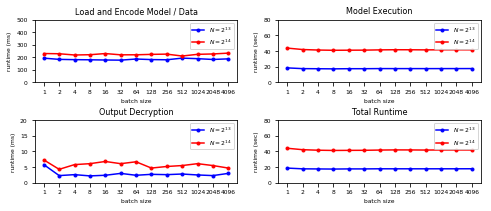

In [8]:
def parse_results_from_cpp_file(file_name):

    poly_modulus_regex = r'.*poly_modulus: (.*)'
    load_model_regex = r'.*sw_load_model: (.*)ms'
    encrypt_input_regex = r'.*sw_encrypt_input: (.*)ms'
    run_model_regex = r'.*sw_run_model: (.*)ms'
    #decrypt_output_regex = r'.*sw_decrypt_output: (.*)ms'
    # This only decodes the output, which is already decrypted
    
    decrypt_output_regex =r'.*Result.* took (.*)ms'
    
    global_regex = r'.*sw_global: (.*)ms'
    batch_size_regex = r'.*of (.*) elements'

    runtimes = []
    poly_modulus = None
    load_model = None
    encrypt_input = None
    run_model = None
    decrypt_output = None
    global_time = None
    batch_size = None

    batch_size_count = 0
    with open(file_name) as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            if re.match(poly_modulus_regex, line):
                match = re.match(poly_modulus_regex, line)
                poly_modulus = int(match.groups()[0])
            elif re.match(load_model_regex, line):
                match = re.match(load_model_regex, line)
                load_model = int(match.groups()[0])  
            elif re.match(encrypt_input_regex, line):
                match = re.match(encrypt_input_regex, line)
                encrypt_input = int(match.groups()[0])  
            elif re.match(run_model_regex, line):
                match = re.match(run_model_regex, line)
                run_model = int(match.groups()[0])
            elif re.match(decrypt_output_regex, line):
                match = re.match(decrypt_output_regex, line)
                decrypt_output = int(match.groups()[0])
            elif re.match(global_regex, line):
                match = re.match(global_regex, line)
                global_time = int(match.groups()[0])
            elif re.match(batch_size_regex, line):
                match = re.match(batch_size_regex, line)
                batch_size = int(match.groups()[0])

                batch_size_count += 1

                # Skip warmup:
                if batch_size_count > 1:
                    runtime_tuple = (poly_modulus, batch_size, encrypt_input + load_model, run_model, decrypt_output, global_time)
                    
                    #print('File: ', file_name, " n: ", poly_modulus, "batch_size: ", batch_size, (encrypt_input, run_model, decrypt_output, global_time))
                    runtimes.append(runtime_tuple)                
                
    return runtimes

def get_simd_avg_results():
    all_results = []

    # Read exp_1.txt, exp_1.txt, ..., exp_10.txt

    file_names_13 = ['./results/simd/exp13_%s.txt' % i for i in range(1,11)]
    file_names_14 = ['./results/simd/exp14_%s.txt' % i for i in range(1,11)]
    file_names = file_names_13 + file_names_14
    for file_name in file_names:
        results_from_file = parse_results_from_cpp_file(file_name)
        all_results.extend(results_from_file)  

    batch_sizes = [2**n for n in range(13)]

    sum_results = {8192:{}, 16384:{}}
    for batch_size in batch_sizes:
        sum_results[8192][batch_size] = (0, 0, 0, 0)
        sum_results[16384][batch_size] = (0, 0, 0, 0)

    for result in all_results:
        n = result[0]
        batch_size = result[1]
        sum_results[n][batch_size] = tuple(map(sum, zip(sum_results[n][batch_size], result[2:])))    

    #print('sum_results', sum_results)    

    avg_results = {8192:{}, 16384:{}}
    for batch_size in batch_sizes:
        avg_results[8192][batch_size] = [float(x) / len(file_names_13) for x in sum_results[8192][batch_size]]
        avg_results[16384][batch_size] = [float(x) / len(file_names_14) for x in sum_results[16384][batch_size]]

    #print('avg_results[8192]', avg_results[8192])
    #print('avg_results[16384]', avg_results[16384])
    
    return avg_results
    
def make_simd_plot(avg_results):

    batch_sizes = [2**n for n in range(13)]

    N13_encryption = [avg_results[8192][bs][0] for bs in batch_sizes]
    N14_encryption = [avg_results[16384][bs][0] for bs in batch_sizes]
    N13_execution = [avg_results[8192][bs][1]/1000. for bs in batch_sizes]
    N14_execution = [avg_results[16384][bs][1]/1000. for bs in batch_sizes]
    N13_decryption = [avg_results[8192][bs][2] for bs in batch_sizes]
    N14_decryption = [avg_results[16384][bs][2] for bs in batch_sizes]
    N13_total = [avg_results[8192][bs][3]/1000. for bs in batch_sizes]
    N14_total = [avg_results[16384][bs][3]/1000. for bs in batch_sizes]

    fig, axarr = plt.subplots(2, 2, figsize=(8,3))

    #fig, ax = plt.subplots()
    ax = axarr[0,0]
    ax.plot(batch_sizes, N13_encryption, marker='.', color='b', label=r'$N=2^{13}$')
    # ax.errorbar(batch_sizes, sw_encrypt_input_means_13, yerr=sw_encrypt_input_stds_13, fmt='o', color='b')
    ax.plot(batch_sizes, N14_encryption, marker='.', color='r', label=r'$N=2^{14}$')
    # ax.errorbar(batch_sizes, sw_encrypt_input_means_14, yerr=sw_encrypt_input_stds_14, fmt='o', color='r')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_title("Load and Encode Model / Data", fontsize=8)
    plt.xticks(batch_sizes)
    ax.set_xticks(batch_sizes)
    ax.set_xlabel("batch size", fontsize=6)
    ax.set_ylabel("runtime (ms)", fontsize=6)
    ax.set_ylim((0, 500))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(loc='upper right', prop={'size': 6})

    #fig, ax = plt.subplots()
    ax = axarr[0,1]
    ax.plot(batch_sizes, N13_execution, marker='.', color='b', label=r'$N=2^{13}$')
    # ax.errorbar(batch_sizes, sw_run_model_means_13, yerr=sw_run_model_stds_13, fmt='o', color='b')
    ax.plot(batch_sizes, N14_execution, marker='.', color='r', label=r'$N=2^{14}$')
    # ax.errorbar(batch_sizes, sw_run_model_means_14, yerr=sw_run_model_stds_14, fmt='o', color='r')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_title("Model Execution", fontsize=8)
    plt.xticks(batch_sizes)
    ax.set_xticks(batch_sizes)
    ax.set_xlabel("batch size", fontsize=6)
    ax.set_ylabel("runtime (sec)", fontsize=6)
    ax.set_ylim((0, 80))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(prop={'size': 8})
    ax.legend(loc='upper right', prop={'size': 6})

    #fig, ax = plt.subplots()
    ax = axarr[1, 0]
    ax.plot(batch_sizes, N13_decryption, marker='.', color='b', label=r'$N=2^{13}$')
    # ax.errorbar(batch_sizes, sw_decrypt_output_means_13, yerr=sw_decrypt_output_stds_13, fmt='o', color='b')
    ax.plot(batch_sizes, N14_decryption, marker='.', color='r', label=r'$N=2^{14}$')
    # ax.errorbar(batch_sizes, sw_decrypt_output_means_14, yerr=sw_decrypt_output_stds_14, fmt='o', color='r')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_title("Output Decryption", fontsize=8)
    plt.xticks(batch_sizes)
    ax.set_xticks(batch_sizes)
    ax.set_xlabel("batch size", fontsize=6)
    ax.set_ylabel("runtime (ms)", fontsize=6)
    ax.set_ylim((0, 20))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(prop={'size': 8})
    ax.legend(loc='upper right', prop={'size': 6})

    ax = axarr[1,1]
    #fig, ax = plt.subplots()
    ax.plot(batch_sizes, N13_total, marker='.', color='b', label=r'$N=2^{13}$')
    # ax.errorbar(batch_sizes, sw_ec_run_dc_means_13, yerr=sw_ec_run_dc_stds_13, fmt='o', color='b')
    ax.plot(batch_sizes, N14_total, marker='.', color='r', label=r'$N=2^{14}$')
    # ax.errorbar(batch_sizes, sw_ec_run_dc_means_14, yerr=sw_ec_run_dc_stds_14, fmt='o', color='r')
    ax.set_xscale('log', basex=2)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_title("Total Runtime", fontsize=8)
    ax.set_xticks(batch_sizes)
    ax.set_xlabel("batch size", fontsize=6)
    ax.set_ylabel("runtime (sec)", fontsize=6)
    ax.set_ylim((0, 80))
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.legend(loc='upper right', prop={'size': 6})

    fig.subplots_adjust(hspace=0.6, wspace=0.2)

    plt.savefig('simd.png', dpi=300, bbox_inches='tight')
    plt.show()
    
make_simd_plot(get_simd_avg_results())

In [4]:
def direct_vs_tf_results():
    python_13_times, cpp_13_times = parse_results_from_python_file("./results/exp13_bs1_enc_data.txt")
    python_14_times, cpp_14_times = parse_results_from_python_file("./results/exp14_bs1_enc_data.txt")

    table_str = '''\\begin{tabular}{|c|c|c|c|}
	\hline
	$N$ & TF + nGraph-HE & Direct nGraph-HE \\\\ \\hline \n'''
	
    
    N13_tf_mean = np.round(np.mean(python_13_times), 2)
    N13_tf_std = np.round(np.std(python_13_times), 2)
    N13_direct_mean = np.round(np.mean(cpp_13_times), 2)
    N13_direct_std = np.round(np.std(cpp_13_times), 2)
    
    table_str += '$2^{13}$ & ' + str(N13_tf_mean) + ' $\pm$ ' + str(N13_tf_std) 
    table_str += ' & ' + str(N13_direct_mean) + ' $\pm$ ' + str(N13_direct_std) + '\\\\\n'
    
    N14_tf_mean = np.round(np.mean(python_14_times), 2)
    N14_tf_std = np.round(np.std(python_14_times), 2)
    N14_direct_mean = np.round(np.mean(cpp_14_times), 2)
    N14_direct_std = np.round(np.std(cpp_14_times), 2)
    
    table_str += '$2^{14}$ & ' + str(N14_tf_mean) + ' $\pm$ ' + str(N14_tf_std) 
    table_str += ' & ' + str(N14_direct_mean) + ' $\pm$ ' + str(N14_direct_std) + '\\\\\n'
    
    table_str += '''\t\hline\n\end{tabular}'''
    
       
    print(table_str)
    
    n13_overhead = np.round((np.mean(python_13_times) - np.mean(cpp_13_times)) / np.mean(cpp_13_times) * 100, 2) 
    n14_overhead = np.round((np.mean(python_14_times) - np.mean(cpp_14_times)) / np.mean(cpp_14_times) * 100, 2)
    print('TF overhead:',max(n13_overhead, n14_overhead),'%')
    
direct_vs_tf_results()

start time 1900-01-01 13:47:12.889242
end time 1900-01-01 13:47:31.040866
cpp_time 0:00:18.151624
start time 1900-01-01 13:47:31.071537
end time 1900-01-01 13:47:47.647105
cpp_time 0:00:16.575568
start time 1900-01-01 13:47:47.677068
end time 1900-01-01 13:48:04.242160
cpp_time 0:00:16.565092
start time 1900-01-01 13:48:04.266663
end time 1900-01-01 13:48:20.856575
cpp_time 0:00:16.589912
start time 1900-01-01 13:48:20.883886
end time 1900-01-01 13:48:37.362059
cpp_time 0:00:16.478173
start time 1900-01-01 13:48:37.385803
end time 1900-01-01 13:48:53.810614
cpp_time 0:00:16.424811
start time 1900-01-01 13:48:53.836993
end time 1900-01-01 13:49:10.595975
cpp_time 0:00:16.758982
start time 1900-01-01 13:49:10.618051
end time 1900-01-01 13:49:27.898651
cpp_time 0:00:17.280600
start time 1900-01-01 13:49:27.915921
end time 1900-01-01 13:49:44.644267
cpp_time 0:00:16.728346
start time 1900-01-01 13:49:44.672716
end time 1900-01-01 13:50:01.551493
cpp_time 0:00:16.878777
start time 1900-01-0

In [5]:
def encrypt_data_model_results():
    # Encrypt data
    python_13_times, cpp_13_times = parse_results_from_python_file("./results/exp13_bs1_enc_data.txt")
    python_14_times, cpp_14_times = parse_results_from_python_file("./results/exp14_bs1_enc_data.txt")
    
    enc_data_13_mean = np.round(np.mean(python_13_times), 1)
    enc_data_13_std = np.round(np.std(python_13_times), 1)
    enc_data_14_mean = np.round(np.mean(python_14_times), 1)
    enc_data_14_std = np.round(np.std(python_14_times), 1)
        
    # Encrypt model
    python_13_times, cpp_13_times = parse_results_from_python_file("./results/exp13_bs1_enc_model.txt")
    python_14_times, cpp_14_times = parse_results_from_python_file("./results/exp14_bs1_enc_model.txt")
    
    enc_model_13_mean = np.round(np.mean(python_13_times), 1)
    enc_model_13_std = np.round(np.std(python_13_times), 1)
    enc_model_14_mean = np.round(np.mean(python_14_times), 1)
    enc_model_14_std = np.round(np.std(python_14_times), 1)
    
    # Encrypt both
    python_13_times, cpp_13_times = parse_results_from_python_file("./results/exp13_bs1_enc_both.txt")
    python_14_times, cpp_14_times = parse_results_from_python_file("./results/exp14_bs1_enc_both.txt")
    
    enc_both_13_mean = np.round(np.mean(python_13_times), 1)
    enc_both_13_std = np.round(np.std(python_13_times), 1)
    enc_both_14_mean = np.round(np.mean(python_14_times), 1)
    enc_both_14_std = np.round(np.std(python_14_times), 1)
    
    table_str = '''\\begin{tabular}{|c|c|c|c|}
    \hline
    $N$ & Encrypt data & Encrypt model & Encrypt data and model \\\\
    \hline\n'''
    
    table_str += '$2^{13}$ & ' + str(enc_data_13_mean) + ' $\pm$ ' + str(enc_data_13_std) + ' & '
    table_str += ' \hspace{0.06cm} '+ str(enc_model_13_mean) + ' $\pm$ ' + str(enc_model_13_std) + ' & '
    table_str += '\\hspace{0.12cm}' + str(enc_both_13_mean) + ' $\pm$ ' + str(enc_both_13_std) + ' \\\\\n'
    
    table_str += '$2^{14}$ & ' + str(enc_data_14_mean) + ' $\pm$ ' + str(enc_data_14_std) + ' & '
    table_str += str(enc_model_14_mean) + ' $\pm$ ' + str(enc_model_14_std) + ' & '
    table_str += str(enc_both_14_mean) + ' $\pm$ ' + str(enc_both_14_std) + ' \\\\ '
    
    table_str += '''\t\hline\n\end{tabular}'''  
    
    print(table_str)
    
encrypt_data_model_results() 

start time 1900-01-01 13:47:12.889242
end time 1900-01-01 13:47:31.040866
cpp_time 0:00:18.151624
start time 1900-01-01 13:47:31.071537
end time 1900-01-01 13:47:47.647105
cpp_time 0:00:16.575568
start time 1900-01-01 13:47:47.677068
end time 1900-01-01 13:48:04.242160
cpp_time 0:00:16.565092
start time 1900-01-01 13:48:04.266663
end time 1900-01-01 13:48:20.856575
cpp_time 0:00:16.589912
start time 1900-01-01 13:48:20.883886
end time 1900-01-01 13:48:37.362059
cpp_time 0:00:16.478173
start time 1900-01-01 13:48:37.385803
end time 1900-01-01 13:48:53.810614
cpp_time 0:00:16.424811
start time 1900-01-01 13:48:53.836993
end time 1900-01-01 13:49:10.595975
cpp_time 0:00:16.758982
start time 1900-01-01 13:49:10.618051
end time 1900-01-01 13:49:27.898651
cpp_time 0:00:17.280600
start time 1900-01-01 13:49:27.915921
end time 1900-01-01 13:49:44.644267
cpp_time 0:00:16.728346
start time 1900-01-01 13:49:44.672716
end time 1900-01-01 13:50:01.551493
cpp_time 0:00:16.878777
start time 1900-01-0